In [342]:
    # find closest points on grid
#     point_tree = spatial.cKDTree(xy)
#     #rected = np.zeros([])
#     rected = []
#     for dot in nn_rdp_normed:
#         # This finds the index of all points within distance step/2 of dot point.
#         ind = point_tree.query_ball_point(dot, radius)
#         try:
#             #print(xy[ind])
#             rected.append(xy[ind])
#         except IndexError as Error: 
#             print(ind)
#             print("index 0 is out of bounds for axis 0 with size 0")

#     print("rected")
#     print(rected)
#     print(rected.shape)


    # Example polygon 
    #xy = [[130.21001, 27.200001], [129.52, 27.34], [129.45, 27.1], [130.13, 26.950001]]
           
        
        # for group
#         go.Scatter(
#             x=rected[:, :, 0],
#             y=rected[:, :, 1],
#             mode = 'markers',
#             marker = dict(
#                 color = 'rgb(17, 157, 255)',
#                 size = 10,
#             ),
#             line = dict(
#                 color = ('rgb(22, 96, 167)'),
#                 width = 4,
#                 # dash = 'dash'
#             ),
#             name='group'
#         ),



#         go.Scatter(
#             x=nn_rdp_normed[:, 0],
#             y=nn_rdp_normed[:, 1],
#             mode = 'lines+markers',
#             marker = dict(
#                 color = 'rgb(0,0,0)',
#                 size = 8
#             ), 
#             line = dict(
#                 color = ('rgb(0,0,0)'),
#                 width = 2,
#                 dash = 'dash'),
#             name='normalized nn_rdp'
#         ),
        
#         go.Scatter(
#             x=xy[:, 0],
#             y=xy[:, 1],
#             mode = 'markers',
#             marker = dict(
#                 color = 'rgb(50, 200, 200)',
#                 size = 4
#             ),            
#             name='grid'
#         ),

In [2]:
# from scipy.spatial import ConvexHull
# import matplotlib.pyplot as plt

# hull = ConvexHull(nn1)
# points = nn1

# simple = rdp(points, epsilon=0.00001)


# plt.plot(points[:,0], points[:,1], 'o')
# plt.plot(simple[:,0], simple[:,1], 'o')

# for simplex in hull.simplices:
#     plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

# plt.axis('equal')
# plt.show()

In [195]:
# # normalize xy
# b_zero_xy = b - b[1]

# #normalize rotate
# # print(b_zero_xy[0])

# theta_ = np.arctan2(b_zero_xy[0][1], b_zero_xy[0][0])
# theta = (np.pi-theta_)
# b_ = rotate2(b_zero_xy, theta)
# # print(theta)
# b_rot = b_.T
# b_prol = np.array(b_rot)
# #prolong
# b_prol[1][0] += b_rot[2][0]
# #b_prol_norm = np.array(b_prol)
# #b_prol_norm -= b_prol[1]


# # rotate back
# b_rot_back_ = rotate2(b_prol, -theta)  # FIXME
# b_rot_back = b_rot_back_.T
# print(b_rot_back)

# # final
# b_back = b_rot_back + b[1]


# # # normalize xy back
# # points_ += points[lfi]

Общая цель преобразования:
1. Спрямление углов
2. Минимизация количества вершин
3. Сохранение высокого IoU с исходным контуром
4. *1 Улучшение IoU с gt по сравнению с исходным
5. **2 Обрабатывать случаи с не прямоугольными домами

https://ru.wikipedia.org/wiki/GeoJSON

https://habr.com/ru/company/yandex/blog/431108/

Алгоритм Рамера — Дугласа — Пекера: https://ru.wikipedia.org/wiki/Алгоритм_Рамера_—_Дугласа_—_Пекера

https://rdp.readthedocs.io/en/latest/

Searching for a Compressed Polyline with a Minimum Number of Vertices: https://arxiv.org/abs/1504.06584

In [313]:
import geojson
import shapely
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from rdp import rdp
import scipy.spatial as spatial
from shapely.geometry import box, Polygon
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from scipy.spatial import distance

from itertools import chain

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [4]:
# this is for calculating Intersection over Union
# metrics of success

def simplify_as_rectangle(geometry, min_area=300, tolerance=0.15):
    rect = geometry.minimum_rotated_rectangle

    if geometry.area < min_area:
        return rect

    elif (1 - geometry.area / rect.area) <= tolerance:
        return rect

    else:
        return geometry

In [356]:
def rotate2(points, angle):
    c, s = np.cos(angle), np.sin(angle)
    R = np.array(((c,-s), (s, c)))
    return np.dot(R, points[:, :2].T)

def find_finish_point_of_longest_side(points):
    # a = (1, 2, 3)
    # b = (4, 5, 6)
    # dst = distance.euclidean(a, b)
    
    # find longest side
    longest_side = distance.euclidean(points[0], points[1])
    
    for i, val in enumerate(points[:-1]):
        if distance.euclidean(val, points[i+1]) > longest_side:
            longest_side = distance.euclidean(val, points[i+1])
            longest_start = points[i]
            longest_finish = points[i+1]
            longest_finish_index = i+1
#     print("longest_side", longest_side)
#     print("longest_start", longest_start)
#     print("longest_finish", longest_finish)
    return longest_finish_index

In [357]:
a = np.array([[10, 2], [12, 8], [7, 14], [5, 4], [10, 2]])

def rectify(b):
    """
    points np.array([[x, y], [x, y]...])
    1) find longest side
    2) 
    """  
    
    lfi = find_finish_point_of_longest_side(b)  # longest_finish_index

    # normalize xy
    b_zero_xy = b - b[lfi]
    
    # rotate normalised
    theta_ = np.arctan2(b_zero_xy[lfi-1][1], b_zero_xy[lfi-1][0])
    theta = (np.pi-theta_)
    b_ = rotate2(b_zero_xy, theta)
    b_rot = b_.T
    b_prol = np.array(b_rot)
    
    # prolong
    b_prol[lfi][0] += b_rot[lfi+1][0]
    
    # rotate back
    b_rot_back_ = rotate2(b_prol, -theta)  # FIXME
    b_rot_back = b_rot_back_.T

    # move back to origin (denormalize)
    b_back = b_rot_back + b[lfi]
    
    return b_back

rect_a = rectify(a)

In [358]:
a = np.array([[10, 2], [12, 8], [7, 14], [5, 6]])

def rectify(polygon):
    """
    points np.array([[x, y], [x, y]...])
    1) find longest side
    2) 
    """  
    
#     print("input polygon")
#     print(polygon)
#     print(" ")
    shape = polygon.shape
    lfi = find_finish_point_of_longest_side(polygon)  # Longest Finish Index
    
    # roll vertices so array starts with the calculated lfi
    # ex: lfi = 3
    # orig: [1, 2, 3, 4]
    # rolled: [3, 4, 1, 2]
    
    polygon_rolled = np.roll(polygon, -lfi+1, axis=0)
    
#     print("polygon_rolled")
#     print(polygon_rolled)
    # rectified = np.zeros(shape, dtype=np.float32)
    rectified = np.copy(polygon_rolled)
    rectified = np.array(rectified, dtype=np.float32)
    for i, vert in enumerate(polygon_rolled[:-2]):
        print(i, vert)
        
        # normalize xy (move all to zero)
        k = polygon_rolled - polygon_rolled[i]

        # rotate normalised
        theta_ = np.arctan2(k[i-1][1], k[i-1][0])
        theta = (np.pi-theta_)
        b_ = rotate2(k, theta)
        b_rot = b_.T
        b_prol = np.array(b_rot)

        # prolong
        nextind = (i+1)%shape[0]  # otherwise IndexError occurs
        b_prol[i][0] += b_rot[nextind][0]

        # rotate back
        b_rot_back_ = rotate2(b_prol, -theta)
        b_rot_back = b_rot_back_.T

        # move back to origin (denormalize)
        b_back = b_rot_back + polygon_rolled[i]
        print(" ")
        #print("b_back i", b_back[i])
        #print(" ")
        rectified[i] = b_back[i]
    print(rectified)
        
    return rectified

rect_a = rectify(gd1)

0 [37.77095556 55.91731829]
 
1 [37.77076479 55.91747591]
 
2 [37.77085846 55.91751151]
 
3 [37.77090965 55.91746922]
 
4 [37.77101647 55.91750982]
 
5 [37.77110252 55.91743872]
 
6 [37.77099571 55.91739812]
 
[[37.77084  55.917274]
 [37.7708   55.917446]
 [37.77089  55.917522]
 [37.770954 55.917435]
 [37.77107  55.91753 ]
 [37.771057 55.917473]
 [37.770996 55.917397]
 [37.770996 55.917397]
 [37.77105  55.917355]]


In [359]:
import numpy as np
from shapely.geometry import Point
from shapely.geometry import LineString

point = Point(1.2, 0.5)
line = LineString([(0, 1), (1, 1)])

x = np.array(point.coords[0])
print(x)
u = np.array(line.coords[0])
v = np.array(line.coords[len(line.coords)-1])

n = v - u
n /= np.linalg.norm(n, 2)

P = u + n*np.dot(x - u, n)
print(P) #0.2 1.

[1.2 0.5]
[1.2 1. ]


In [360]:
from shapely.geometry import Polygon, MultiPoint, MultiLineString

#polygon = Polygon(gd1)

import numpy as np
from shapely.geometry import Point
from shapely.geometry import LineString


shape = polygon.shape
lfi = find_finish_point_of_longest_side(polygon)  # Longest Finish Index

polygon_rolled = np.roll(polygon, -lfi+1, axis=0)

rectified = np.copy(polygon_rolled)
rectified = np.array(rectified, dtype=np.float32)

for i, vert in enumerate(polygon_rolled):
    print(i, vert)

    nextind = (i+1)%shape[0]  # otherwise IndexError occurs

    x_next = polygon_rolled[nextind][0]
    y_next = polygon_rolled[nextind][1]

    x_curr = polygon_rolled[i][0]
    y_curr = polygon_rolled[i][1]

    x_prev = polygon_rolled[i-1][0]
    y_prev = polygon_rolled[i-1][1]

    point = Point(x_next, y_next)
    line = LineString([(x_prev, y_prev), (x_curr, y_curr)])

    x = np.array(point.coords[0])
    u = np.array(line.coords[0])
    v = np.array(line.coords[len(line.coords)-1])  # last

    n = v - u
    n /= np.linalg.norm(n, 2)

    P = u + n*np.dot(x - u, n)
    rectified[i] = P
    print(P) #0.2 1.

    return rectified



AttributeError: 'Polygon' object has no attribute 'shape'

In [361]:
data = [
    go.Scatter(
        x=gd1[:, 0],
        y=gd1[:, 1],
        mode = 'lines+markers',
        marker = dict(
            color = 'rgb(255,105,180)',
            size = 8
        ), 
        line = dict(
            color = ('rgb(255,105,180)'),
            width = 2,
        ),
        name='original'
    ),
    
    go.Scatter(
        x=rect_a[:, 0],
        y=rect_a[:, 1],
        mode = 'lines+markers',
        marker = dict(
            color = 'rgb(17, 157, 255)',
            size = 10,
        ),
        line = dict(
            color = ('rgb(22, 96, 167)'),
            width = 4,
            dash = 'dash'
        ),
        name='rectified'
    ),
]
layout= go.Layout(
    title= 'simplified nn',
    xaxis= dict(
        title= 'x',
    ),
    yaxis=dict(
        title= 'y',
        scaleanchor="x",
        scaleratio=1,
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

https://stackoverflow.com/questions/32424604/find-all-nearest-neighbors-within-a-specific-distance

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query_ball_tree.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query_ball_point.html#scipy.spatial.cKDTree.query_ball_point

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html

https://en.wikipedia.org/wiki/K-d_tree

https://en.wikipedia.org/wiki/Ramer–Douglas–Peucker_algorithm

http://scikit-image.org/docs/dev/auto_examples/edges/plot_polygon.html

interpolation and projection

https://stackoverflow.com/questions/49061521/projection-of-a-point-to-a-line-segment-python-shapely

shapely

https://shapely.readthedocs.io/en/latest/manual.html#collections-of-lines

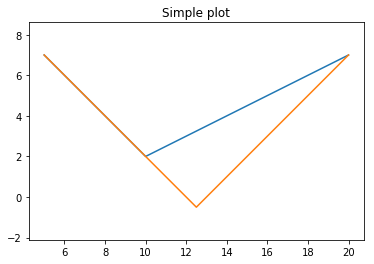

In [362]:
f, ax = plt.subplots()
ax.plot(b[:, 0], b[:, 1])
ax.plot(b_back[:, 0], b_back[:, 1])
ax.set_title('Simple plot')
plt.axis('equal')
plt.show()

In [363]:
data = [
    go.Scatter(
        x=b[:, 0],
        y=b[:, 1],
        name='old'
    ),
    
    # no
#     go.Scatter(
#         x=b_zero_xy[:, 0],
#         y=b_zero_xy[:, 1],
#         name='b_zero_xy'
#     ),
    
    
#     go.Scatter(
#         x=b_rot[:, 0],
#         y=b_rot[:, 1],
#         name='b_rot'
#     ),
#     go.Scatter(
#         x=b_prol[:, 0],
#         y=b_prol[:, 1],
#         name='b_prol'
#     ),

    
    # no
#     go.Scatter(
#         x=b_rot_back[:, 0],
#         y=b_rot_back[:, 1],
#         name='b_rot_back'
#     ),
    go.Scatter(
        x=b_back[:, 0],
        y=b_back[:, 1],
        name='b_back'
    ),
]

layout= go.Layout(
    title= 'simplified nn',
    xaxis= dict(
        title= 'x',
    ),
    yaxis=dict(
        title= 'y',
        scaleanchor="x",
        scaleratio=1,
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [364]:
with open("100_pred4.geojson") as f:
    geodata = geojson.load(f)
    nn = np.array(geodata['features'][3]['geometry']["coordinates"][0])
    nn_rdp = rdp(nn, epsilon=0.00003)  # Ramer-Douglas-Peucker Algorithm

data = [
#     go.Scatter(
#         x=gd0[:, 0],
#         y=gd0[:, 1],
#         name='true0'
#     ),
    go.Scatter(
        x=nn[:, 0],
        y=nn[:, 1],
        name='true1',
        mode = 'lines+markers',
        marker = dict(
            color = 'rgb(255,105,180)',
            size = 8
        ), 
        line = dict(
            color = ('rgb(255,105,180)'),
            width = 2,
        ),
    ),
]

layout= go.Layout(
    title= 'Geodesists',
    xaxis= dict(
        title= 'x',
    ),
    yaxis=dict(
        title= 'y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [365]:
def plot_nn(file, n_house, epsilon = 0.00002):
    with open(file) as f:
        geodata = geojson.load(f)
        nn = np.array(geodata['features'][n_house]['geometry']["coordinates"][0])
        nn_rdp = rdp(nn, epsilon=epsilon)  # Ramer-Douglas-Peucker Algorithm

    data = [
        go.Scatter(
            x=nn[:, 0],
            y=nn[:, 1],
            mode = 'lines+markers',
            name='neural_net'
        ),
        go.Scatter(
            x=nn_rdp[:, 0],
            y=nn_rdp[:, 1],
            mode = 'lines+markers',
            name='processed'
        ),
    ]

    layout= go.Layout(
        title= 'NNetwork VS rdp',
        xaxis= dict(
            title= 'x',
        ),
        yaxis=dict(
            title= 'y',
        ),
        showlegend= True
    )
    fig= go.Figure(data=data, layout=layout)
    iplot(fig)
    
plot_nn(predicted, 10, epsilon = 0.00002)  # 10, 14

### Parse geodedics and processed data

In [355]:
# gd = geodesists
with open("100_gt.geojson") as f:
    gd = geojson.load(f)

gd0 = np.array(gd['features'][0]['geometry']["coordinates"][0][0])
gd1 = np.array(gd['features'][1]['geometry']["coordinates"][0][0])

In [354]:
predicted = "100_pred4.geojson"
geodetic = "100_gt.geojson"

Придумать недостающие этапы второго алгоритма из статьи яндекса, попробовать./

алгоритм состоит из трёх действий: 

1) Построить квадратную сетку в пространстве с центром в нуле.

2) На точках сетки, которые расположены не дальше некоторого расстояния от исходного контура, построить различные многоугольники.

3) Выбрать многоугольник с минимальным количеством вершин.

- Add initial image with houses
- считаем, что все углы дб прямыми

In [347]:
def snap_to_grid(contour, step, half_side, radius):
    """
    contour: array of contour, already processed with RDP
    step: distance between dots in a grid
    half_side: one half of a grid-square side
    radius: snap to closest point within defined radius  

    # FIXME should snap to closest point, but include set of points and then 
    # choose polygon with minimum number of vertices
    
    output: array of coords
    """

    # making grid
    end = half_side + 0.00001
    xy = np.mgrid[-half_side:end:step, -half_side:end:step].reshape(2,-1).T    

    # processed with rdp and normed
    mc = np.mean(nn_rdp, axis=0)
    nn_rdp_normed = list(nn_rdp)
    nn_rdp_normed -= mc

#         # raw normed
#         nn_normed = list(nn)
#         nn_normed -= mc

    # find closest points on grid
    point_tree = spatial.cKDTree(xy)
    rected = []
    for dot in nn_rdp_normed:
        # find index of point in a grid within distance R from dot.
        ind = point_tree.query_ball_point(dot, radius)
        try:
            rected.append(xy[ind][0])
        except IndexError as Error: 
            print(ind)
            print("index 0 is out of bounds for axis 0 with size 0")

    grid_snapped = np.array(rected)
    grid_snapped += mc

    return grid_snapped


def projection(a, b, c):
    """
    projection of (b, c) onto (b, a)
    """
    ba = a - b
    bc = c - b
    return b + ba * (ba @ bc) / (ba @ ba)


def rectify(contour):
    res_contour = np.array(contour)

    lengths = np.asarray(
        [np.linalg.norm(contour[i+1] - contour[i]) for i in range(contour.shape[0] - 1)]
    )
    max_len_ind = int(np.argmax(lengths))
    prev_i = max_len_ind
    for i in chain(range(max_len_ind + 1, lengths.shape[0]), range(0, max_len_ind)):
        pr = projection(res_contour[prev_i], res_contour[i], res_contour[i + 1])
        res_contour[i] = pr
        prev_i = i

    res_contour[-1] = res_contour[0]
    
    return res_contour

    
def calculate_IoU(processed, raw):
    rectified_iou = Polygon(processed)
    nn_iou = Polygon(raw)

    int_area = rectified_iou.intersection(nn_iou).area # The intersection
    polygons = [rectified_iou, nn_iou]
    u = cascaded_union(polygons)  # The Union
    print("IoU", int_area/u.area) 

In [348]:
def square_grid(file, n_house, epsilon = 0.00002, step = 0.00005, half_side = 0.0004, radius = 0.00005):
    """
    epsilon - threshold. Bigger epsilon produces less points.
    step - between grid dots
    half_side - half of a grid side
    
    dot: (x, y)
    grid: [[x1, y1], [x2, y2]...]
    step: step of the grid, closest point is lying in range of that step
    
    find all points whos x and y coords differ from goal_dot not more than step distance
    find closest among them
    
    """
    
    with open(file) as f:
        geodata = geojson.load(f)
        nn = np.array(geodata['features'][n_house]['geometry']["coordinates"][0])
        
    nn_rdp = rdp(nn, epsilon=epsilon)  # Ramer-Douglas-Peucker Algorithm
    grid_snapped = snap_to_grid(nn_rdp, step, half_side, radius)
    rectified = rectify(grid_snapped)  # using projections
    
    data = [
        go.Scatter(
            x=nn[:, 0],
            y=nn[:, 1],
            mode = 'lines',
            line = dict(
                color = ('rgb(255,105,180)'),
                width = 1,
            ),
            name='raw'
        ),
        
        go.Scatter(
            x=grid_snapped[:, 0],
            y=grid_snapped[:, 1],
            mode = 'lines+markers',
            marker = dict(
                color = 'rgb(0, 200, 0)',
                size = 8,
            ),
            line = dict(
                color = ('rgb(0, 200, 0)'),
                width = 4,
                dash = 'dash'
            ),
            name='found'
        ),
    
        go.Scatter(
            x=rectified[:, 0],
            y=rectified[:, 1],
            mode = 'lines+markers',
            marker = dict(
                color = 'rgb(17, 157, 255)',
                size = 10,
            ),
            line = dict(
                color = ('rgb(22, 96, 167)'),
                width = 4,
                # dash = 'dash'
            ),
            name='final'
        ),
    ]

    layout= go.Layout(
        title= 'simplified nn',
        xaxis= dict(
            title= 'x',
        ),
        yaxis=dict(
            title= 'y',
            scaleanchor="x",
            scaleratio=1,
        ),
        showlegend= True
    )
    fig= go.Figure(data=data, layout=layout)
    iplot(fig)
    
    calculate_IoU(rectified, nn)

In [349]:
square_grid(predicted, 10, epsilon = 0.000015, step = 0.00003, half_side = 0.0003, radius = 0.00002)

IoU 0.0


In [350]:
square_grid(predicted, 34, epsilon = 0.000015, step = 0.00003, half_side = 0.0004, radius = 0.00002)

IoU 0.0


In [351]:
square_grid(predicted, 3, epsilon = 0.000012, step = 0.00003, half_side = 0.0002, radius = 0.00002)

IoU 0.7503679130764881


In [352]:
square_grid(predicted, 37, epsilon = 0.000004, step = 0.00002, half_side = 0.0003, radius = 0.00001)

[]
index 0 is out of bounds for axis 0 with size 0
[]
index 0 is out of bounds for axis 0 with size 0


IoU 0.0


In [353]:
square_grid(predicted, 22, epsilon = 0.000015, step = 0.00003, half_side = 0.0003, radius = 0.00002)

IoU 0.0


In [323]:
square_grid(predicted, 7, epsilon = 0.000015, step = 0.00002, half_side = 0.00035, radius = 0.00002)

IoU 0.8894325531824627


In [324]:
square_grid(predicted, 8, epsilon = 0.000006, step = 0.00002, half_side = 0.00015, radius = 0.000015)

IoU 0.8469188650962775


# IoU 0.9114357105838641
# IoU 0.9683536657663233
# IoU 0.9683536657663233
# IoU 0.88652260190088
# IoU 0.8469188650962775